In [1]:
import numpy as np
import scipy.sparse as sps
np.set_printoptions(precision=2)

import torch
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim

import qiskit
from qiskit.visualization import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize':(15, 6)})

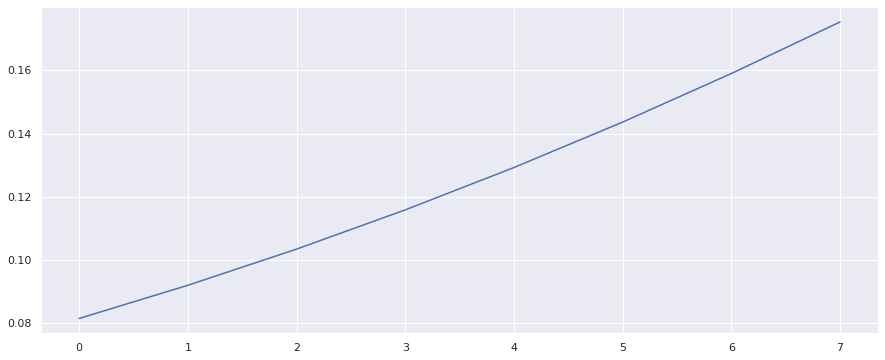

In [28]:
def gaussian(n_qubits, mu, sigma):
    x = np.arange(2 ** n_qubits)
    probs = 1. / np.sqrt(2 * np.pi * sigma ** 2) 
    probs *= np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))
    return probs / probs.sum()

def generate_pair(n_qubits):
    pairs = [(i, i + 1) for i in range(n_qubits - 1)]
    pairs.append((n_qubits - 1, 0))
    return pairs

n_qubits = 3
n_layers = 3

data = gaussian(n_qubits, mu = 2 ** 5 - 0.5, sigma = 2 ** 4)

plt.plot(data)
plt.show()

## Quantum Born Machine

In [29]:
class BornMachine:
    def __init__(self, backend, iterations, n_qubits, n_layers, 
                 pair_generator=generate_pair):
        self.backend = backend
        self.iterations = iterations
        
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.pair_generator = pair_generator
        
        self.circuit = qiskit.QuantumCircuit(self.n_qubits)
        self.params = {}
        for layer in range(n_layers):
            self._create_layer(layer)
        self.circuit.measure_all()
        
        self._init_param_values()
    
    def _init_param_values(self):
        self.params_vals = np.array([])
        for key in self.params.keys():
            self.params_vals = np.append(self.params_vals, np.random.random())
        
    def _create_layer(self, layer):
        # Insert RZ, RX, RZ rotation on each qubit
        for qubit in range(self.n_qubits):
            key = "{}:{}:{}".format(layer, qubit, 0)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rz(self.params[key], qubit)
            
            key = "{}:{}:{}".format(layer, qubit, 1)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rx(self.params[key], qubit)
            
            key = "{}:{}:{}".format(layer, qubit, 2)
            self.params[key] = qiskit.circuit.Parameter(key)
            self.circuit.rz(self.params[key], qubit)
        
        # Entangle qubits
        if layer != self.n_layers - 1:
            for qubit_1, qubit_2 in self.pair_generator(self.n_qubits):
                self.circuit.cx(qubit_1, qubit_2)
            self.circuit.barrier()
        
    def _bind_parameters(self, values):
        # TODO: set leading and trailing Rz to disabled
        parameter_binds = {}

        for key, value in zip(list(self.params.keys()), values):
            parameter_binds[self.params[key]] = value
        return parameter_binds
    
    def __call__(self, params=None):
        if params is None:
            params = self.params_vals
        job = qiskit.execute(self.circuit, self.backend, shots=self.iterations,
                             parameter_binds=[self._bind_parameters(params)])

        result = job.result().get_counts(self.circuit)

        counts = np.array(list(result.values()))
        states = [int(key, 2) for key in np.array(list(result.keys()))]

        probabilities = np.zeros(2 ** len(self.circuit.qubits)) 
        probabilities[states] = counts
        probabilities /= self.iterations

        return np.array(probabilities)

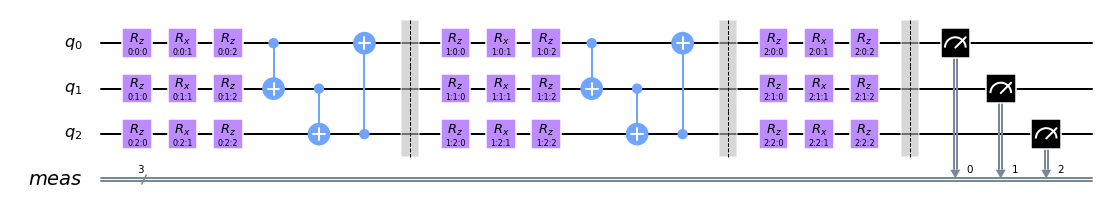

In [30]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

model = BornMachine(simulator, 100, n_qubits, n_layers)
model.circuit.draw()

In [74]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        probabilities = ctx.quantum_circuit(input.data.numpy())
        result = torch.tensor([probabilities])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        input, probabilities = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.eye(len(input_list)) * ctx.shift / 2
        shift_left = input_list - np.eye(len(input_list)) * ctx.shift / 2

        gradients = []
        for i in range(len(input_list)):
            probs_right = ctx.quantum_circuit(shift_right[i])
            probs_left  = ctx.quantum_circuit(shift_left[i])
            
            gradient = probs_right - probs_left
            gradients.append(gradient)
        gradients = torch.tensor(gradients)
        chain_gradients = gradients.float() @ grad_output.float().T
        chain_gradients = torch.flatten(chain_gradients)
        return chain_gradients, None, None

class Hybrid(nn.Module):
    def __init__(self, n_qubits, n_layers, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = BornMachine(backend, shots, n_qubits, n_layers)
        self.shift = shift
        self.thetas = torch.nn.Parameter(torch.tensor(self.quantum_circuit.params_vals))
        
    def forward(self):
        self.quantum_circuit.params_vals = self.thetas.data.numpy()
        return HybridFunction.apply(self.thetas, self.quantum_circuit, self.shift)

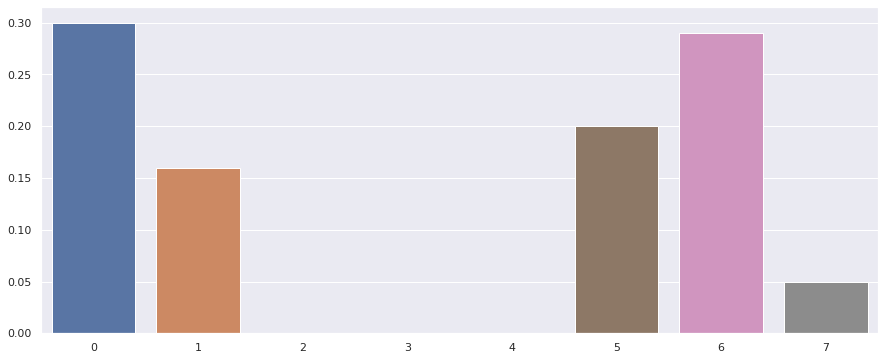

In [32]:
distribution = model()
sns.barplot(x = np.arange(len(distribution)), y = distribution)

In [33]:
class MMDLoss:   
    def __init__(self, basis, sigmas):
        self.sigmas = sigmas
        self.basis = basis
        
        kernel = 0.
        for sigma in sigmas:
            gamma = 1. / (2. * sigma)
            kernel += np.exp(-gamma * (basis[:, None] - basis[None, :]) ** 2)

        self.kernel = torch.tensor(kernel)

    def __call__(self, p_x, p_y):
        return (p_x - p_y) @ self.kernel @ (p_x - p_y).T

In [110]:
hybrid_model = Hybrid(n_qubits, n_layers, simulator, 500, np.pi / 2)
optimizer = optim.Adam(hybrid_model.parameters(), lr=0.05)
loss_func = MMDLoss(np.arange(2 ** n_qubits), [0.25,4])

epochs = 20
loss_list = []

hybrid_model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    # Forward pass
    output = hybrid_model()
    # Calculating loss
    loss = loss_func(output, torch.tensor(data))
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()
    
    loss_list.append(loss)
    print('Training [\t{:.0f}%\t]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1].item()))

Training [	5%	]	Loss: 0.3062
Training [	10%	]	Loss: 0.1817
Training [	15%	]	Loss: 0.0552
Training [	20%	]	Loss: 0.0251
Training [	25%	]	Loss: 0.0267
Training [	30%	]	Loss: 0.0207
Training [	35%	]	Loss: 0.0185
Training [	40%	]	Loss: 0.0165
Training [	45%	]	Loss: 0.0164
Training [	50%	]	Loss: 0.0109
Training [	55%	]	Loss: 0.0100
Training [	60%	]	Loss: 0.0097
Training [	65%	]	Loss: 0.0182
Training [	70%	]	Loss: 0.0187
Training [	75%	]	Loss: 0.0124
Training [	80%	]	Loss: 0.0098
Training [	85%	]	Loss: 0.0073
Training [	90%	]	Loss: 0.0161
Training [	95%	]	Loss: 0.0089
Training [	100%	]	Loss: 0.0105


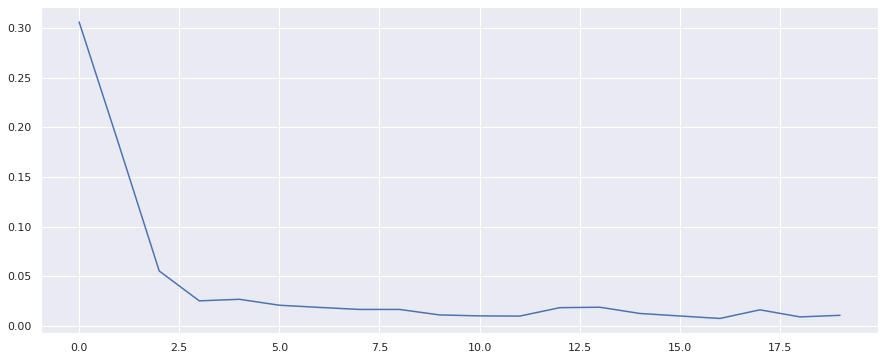

In [111]:
plt.plot(loss_list)

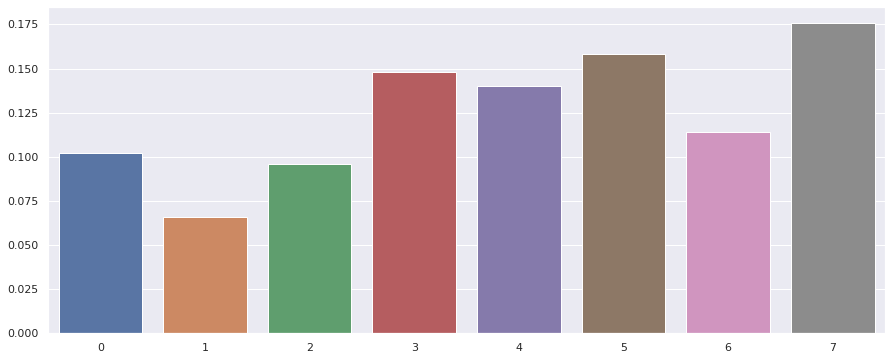

In [112]:
distribution = hybrid_model().detach().numpy()[0]
sns.barplot(x = np.arange(len(distribution)), y = distribution)

#### Literature
"Differentiable learning of quantum circuit Born machines" Liu and Wang & example code that accompanied the paper